In [74]:
import json
import pickle
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from glob import glob

pd.options.mode.chained_assignment = None
sns.set_style("darkgrid")

In [2]:
#### Settings
### Learning Rate for 2NN = 0.1, no learning rate decay

In [3]:
os.chdir("/home/bahy/research/icl-prelab-assignment/")

In [4]:
!pwd

/home/bahy/research/icl-prelab-assignment


In [5]:
datas = []
for file_name in glob("logs_q1/*.txt"):
    print(file_name)
    file = open(file_name, "rb")
    for data in file.readlines():
        if len(data) < 10: # Ignoring blank space/not useful information
            continue
        dict_data = eval(data)
        dict_data['setting'] = file_name.split("/")[1].split("-")[0]
        dict_data['model'] = file_name.split("/")[1].split("-")[-1].split(".")[0]
        datas.append(dict_data)
        
datas = pd.DataFrame(datas)

logs_q1/IID-B10-E1-C0.1-MNIST-2NN.txt
logs_q1/NONIID-B10-E1-C0.1-MNIST-2NN.txt


In [6]:
# Sort the data
ROUNDING_DIGIT = 4

df_metrics = datas.sort_values(by=['setting', 'B', 'C', 'comm_round']).reset_index(drop=True)
df_metrics['train_acc'] = df_metrics['train_acc'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['test_acc'] = df_metrics['test_acc'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['train_loss'] = df_metrics['train_loss'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['test_loss'] = df_metrics['test_loss'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics.head()

,C,B,learning_rate,comm_round,train_acc,test_acc,train_loss,test_loss,val_acc,val_loss,setting,model
0,0.1,10,0.1,1,0.8304,0.8349,0.7483,0.7324,0.8298,0.7466,IID,2NN
1,0.1,10,0.1,2,0.8606,0.8651,0.4973,0.4816,0.8569,0.4951,IID,2NN
2,0.1,10,0.1,3,0.8842,0.8904,0.4091,0.3939,0.8824,0.4065,IID,2NN
3,0.1,10,0.1,4,0.9013,0.9062,0.3506,0.3395,0.9004,0.3457,IID,2NN
4,0.1,10,0.1,5,0.9034,0.9086,0.3233,0.3090,0.9044,0.3155,IID,2NN


In [7]:
df_metrics.tail()

,C,B,learning_rate,comm_round,train_acc,test_acc,train_loss,test_loss,val_acc,val_loss,setting,model
1061,0.1,10,0.1,1004,0.9692,0.9650,0.0947,0.1128,0.9652,0.1166,NONIID,2NN
1062,0.1,10,0.1,1005,0.9709,0.9671,0.0876,0.1059,0.9649,0.1123,NONIID,2NN
1063,0.1,10,0.1,1006,0.9726,0.9687,0.0822,0.1020,0.9670,0.1063,NONIID,2NN
1064,0.1,10,0.1,1007,0.9723,0.9671,0.0844,0.1054,0.9677,0.1094,NONIID,2NN
1065,0.1,10,0.1,1008,0.9744,0.9702,0.0782,0.1014,0.9683,0.1051,NONIID,2NN


In [8]:
df_metrics.groupby(["model", "setting", "B", "C"]).size()

model  setting  B   C  
2NN    IID      10  0.1      58
       NONIID   10  0.1    1008
dtype: int64

In [9]:
table_df = df_metrics.groupby(["model", "setting", "B", "C"]).size().to_frame('comm_round').reset_index()
table_df

,model,setting,B,C,comm_round
0,2NN,IID,10,0.1,58
1,2NN,NONIID,10,0.1,1008


In [102]:
def plot_monotonic_acc(input_df, metrics=["test", "train"]):
    
    min_ylim = []
    for metric in metrics:
        max_val = input_df['%s_acc' % metric][0]
        keep = []
    
        for i in range(len(input_df)):
            current = input_df['%s_acc' % metric][i]
            if max_val <= current:
                keep.append(input_df['comm_round'].index[i])
                max_val = current          
        
        sns.lineplot(data=input_df.iloc[keep], x='comm_round', y='%s_acc' % metric, label="%s_acc" % metric)
        min_ylim.append(input_df.iloc[keep]['%s_acc' % metric].min())
    
    plt.ylim(max(min_ylim), None)
    plt.ylabel("Accuracy")
    plt.xlabel("Communication Rounds")
    plt.title("MNIST %s %s\nB=%s, C=%s" % (input_df['model'].unique()[0], input_df['setting'].unique()[0],\
                                             input_df['B'].unique()[0], input_df['C'].unique()[0]))
    plt.legend(loc='lower right')
    plt.show()

In [103]:
def plot_monotonic_loss(input_df, metrics=["test", "train"]):
    
    max_ylim = []
    for metric in metrics:
        min_val = input_df['%s_loss' % metric][0]
        keep = []
    
        for i in range(len(sample_df)):
            current = input_df['%s_loss' % metric][i]
            if min_val >= current:
                keep.append(input_df['comm_round'].index[i])
                min_val = current          
        
        sns.lineplot(data=input_df.iloc[keep], x='comm_round', y='%s_loss' % metric, label="%s_loss" % metric)
        max_ylim.append(input_df.iloc[keep]['%s_loss' % metric].max())
    
    plt.ylim(None, min(max_ylim))
    plt.ylabel("Loss")
    plt.xlabel("Communication Rounds")
    plt.title("MNIST %s %s\nB=%s, C=%s" % (input_df['model'].unique()[0], input_df['setting'].unique()[0],\
                                             input_df['B'].unique()[0], input_df['C'].unique()[0]))
    plt.legend(loc='upper right')
    plt.show()

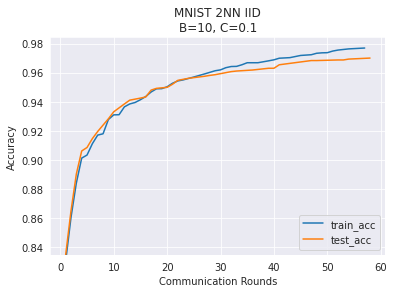

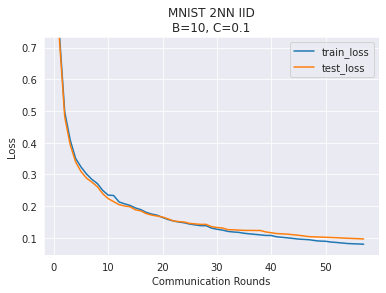

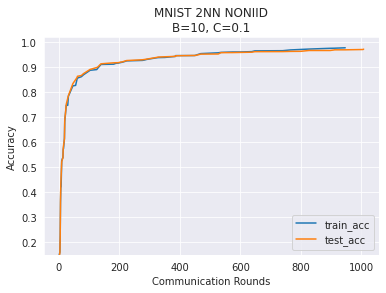

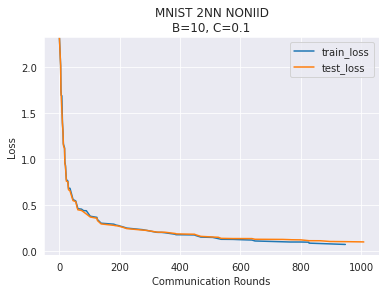

In [104]:
# Plot all accuracy and losses
MODELS = ["CNN", "2NN"]
SETTINGS = ["IID", "NONIID"]
BATCHES = [600, 10]
C_FRACTIONS = [0.0, 0.1, 1.0]

for model in MODELS:
    for setting in SETTINGS:
        for b in BATCHES:
            for c in C_FRACTIONS:
                sample_df = df_metrics[(df_metrics['B']==b) & (df_metrics['C']==c)\
                                       & (df_metrics['setting']==setting) & (df_metrics['model']==model)]\
                                        .reset_index(drop=True)
                if len(sample_df) == 0:
                    continue
                plot_monotonic_acc(sample_df, ['train', 'test'])
                plot_monotonic_loss(sample_df, ['train', 'test'])